In [1]:
import numpy as np
import random
from math import log
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import copy

from collections import deque
from copy import deepcopy
from tqdm import tqdm
import os 
import shutil

In [91]:
# Reading the input file
N,V,c,demand,X,Y = readData('vrp_76_10_1') 

In [87]:
# System Model definition
# The system model will provide feedback to the agent from the environment regarding the next state and the reward given an 
# action in the current state. The task is episodic and will terminate after all the vehicles in the fleet have completed the 
# delivery of the goods. Initially the location of the vehicle will be at the warehouse and the capacity will be set to the 
# maximum capacity of the vehicle. All customer locations will be initialized to the initial demand.
# The definition of the next state has three components of which the location is built within the action, which is defined as 
# the movement to a specific location. If the current capacity of the vehicle is more than the current demand, then the vehicle 
# will deliver the goods to the location. The capacity of the vehicle will be reduced accordingly and the outstanding demand at 
# the location will be set to zero.
# If the vehicle successfully delivers the goods to the location, then the agent will receive a positive reward proportional to 
# the amount of goods delivered. Apart from the delivery component, the cost component will need to be accounted for each action.
# The cost will be computed as the Euclidean distance between the current location and the next location.

max_capacity = c

cost_factor = -1
delivery_factor = 1
unmet_demand_factor = 3

class state:
    def __init__(self,demand,location,capacity,vehicles,actionSpace):
        self.demand = demand
        self.location = location
        self.capacity = capacity
        self.vehicles = vehicles
        self.actionSpace = actionSpace
        self.tempActionSpace = copy.deepcopy(self.actionSpace)
        
    def printState(self):
        print("Demand: "+str(self.demand))
        print("Location: "+str(self.location))
        print("Capacity: "+str(self.capacity))
        print("Vehicles: "+str(self.vehicles))
        print("Action Space: "+str(self.actionSpace))
        print("Temp Action Space: "+str(self.tempActionSpace))

def system_model(currState,action,totDistance):
    
    nextState = copy.deepcopy(currState)
    reward_cost = 0
    reward_delivery = 0
    # Compute the cost component of the reward based on the Euclidean distance between the current and next state
    distance = euclidean_distance(currState.location,action)
    totDistance += distance
    reward_cost += cost_factor * distance
    
    # Check is the destination is the warehouse (location = 0)
    if action == 0:
        nextState.capacity = max_capacity
        nextState.vehicles -= 1
        nextState.tempActionSpace = copy.deepcopy(nextState.actionSpace)
        if nextState.vehicles == 0:
            reward_delivery = sum(nextState.demand)*(-unmet_demand_factor)
    
    # For customer location check if vehicle capacity is more than the demand
    else:
        if (nextState.capacity >= nextState.demand[action]):
            nextState.capacity -= nextState.demand[action]
            reward_delivery = delivery_factor * nextState.demand[action]
            nextState.demand[action] = 0
            nextState.actionSpace.remove(action)
            nextState.tempActionSpace.remove(action)
            
            temporaryActionSpace = copy.deepcopy(nextState.tempActionSpace)
            for i in temporaryActionSpace:
                if nextState.demand[i] > nextState.capacity:
                    nextState.tempActionSpace.remove(i)
            
    nextState.location = action
    reward = reward_cost + reward_delivery

    return nextState,reward,totDistance
    
def euclidean_distance(loc1,loc2):
    distance = ((X[loc2]-X[loc1])**2+(Y[loc2]-Y[loc1])**2)**(1/2)
    return distance
    

In [99]:
#ε-greedy action selection
"""
qsa- Action value function
y,x - Coordinates of current state
epsilon - ε-greedy parameter
"""

def epsilonGreedy(qsa,currState,epsilon):
    tempActionSpace = copy.deepcopy(currState.actionSpace)
    if currState.location!=0 and currState.location in tempActionSpace:
        tempActionSpace.remove(currState.location)
    if random.uniform(0, 1) < epsilon:    #Explore: Select action at random
        action = np.random.choice(tempActionSpace)
    else:                                 #Exploit: Select action based on maximum action value, use random to break ties
        location,capacity,vehicles = currState.location,currState.capacity,currState.vehicles-1
        demandIndex = 0
        for i in currState.demand:
            demandIndex = demandIndex*2+int(i>0)
        qsa_temp = np.array([qsa[location][capacity][vehicles][demandIndex][i] for i in tempActionSpace])
        actionIndex = np.random.choice(np.flatnonzero(qsa_temp == qsa_temp.max())) 
        action = tempActionSpace[actionIndex]
    return action

def updateActionValues(qsa,currState,action,nextState,reward):
    # Update the action values.
    location,capacity,vehicles = currState.location,currState.capacity,currState.vehicles-1
    demandIndex = 0
    for i in currState.demand:
        demandIndex = demandIndex*2+int(i>0)
    
    if nextState.vehicles == 0 :
        qsa[location][capacity][vehicles][demandIndex][action]+=alpha*(reward - qsa[location][capacity][vehicles][demandIndex][action])
    else:      
        nextLocation,nextCapacity,nextVehicles = nextState.location,nextState.capacity,nextState.vehicles-1
        nextDemandIndex = 0
        for i in nextState.demand:
            nextDemandIndex = nextDemandIndex*2+int(i>0)
            
        actionPrime=epsilonGreedy(qsa,nextState,0)
        qsa[location][capacity][vehicles][demandIndex][action]+=alpha*(reward+gamma*qsa[nextLocation][nextCapacity][nextVehicles][nextDemandIndex][actionPrime] - qsa[location][capacity][vehicles][demandIndex][action])

        
        
        
#Visualizing Path
def findPath(qsa):
    currState = copy.deepcopy(startState)
    actions=[]
    totDistance = 0
    while True:
        #currState.printState()
        action = epsilonGreedy(qsa,currState,0)
        actions.append(action)
        currState,reward,totDistance = system_model(currState,action,totDistance)
        #print(actions)
        if currState.vehicles == 0:
            return actions,totDistance
        
def plotPath(actions):
    plt.scatter(X, Y)
    for i in range(len(demand)):
        plt.annotate(str(demand[i]), (X[i], Y[i]),fontsize = 5)
    xpath = [X[0]]
    ypath = [Y[0]]
    for i in actions:
        xpath.append(X[i])
        ypath.append(Y[i])
        if i == 0:
            plt.plot(xpath, ypath)
            xpath = [X[0]]
            ypath = [Y[0]]
            
    plt.plot(xpath, ypath)
    plt.show()
    
    


In [20]:
#Helper Functions

def readData(fileName):
    file1 = open(fileName, 'r') 
    Lines = file1.readlines() 

    demand = []
    X=[]
    Y=[]

    counter = -1 
    for line in Lines: 
        if counter == -1:
            N,V,c = map(int, line.split())
        else:
            d,x,y = map(float, line.split())
            demand.append(d)
            X.append(x)
            Y.append(y)
        counter+= 1
    
    return N,V,c,demand,X,Y
    

In [13]:
# Tabular Q-learning    
# Initialize the state of the system
actionSpace = list(range(N))
startState = state(demand,0,c,V,actionSpace)

#Initialize the hyper-parameters
optInit = 1000
numIter=6000                    #Number of iterations of the algorithm
alpha=0.5                         #Learning Rate
gamma=1                          # Discount Factor - Set to 1 as this is an undiscounted task
epsilon0 = 0.3
     
# Initialize the state action values to zero.
#Each state is defined by location of vehicle, capacity of vehicle, number of vehicles and outstanding demand.
#Frome each state the vehicle can travel to any of the other locations.
qsa=np.ones((N,c+1,V,2**(N-1),N))*optInit  

# Step throught the episodes and update the action value table
rewards = []                  #Array to maintain the rewards for each iteration

for i in range(numIter):
    # Initialize the state of the system
    currState = copy.deepcopy(startState)
    totDistance = 0
    
    epsilon=epsilon0/(i//1000+1)            #Reduce Epsilon as time progresses
    
    sumReward = 0
    
    while True:
        #currState.printState()
        # Check for terminal state
        if currState.vehicles == 0:
            rewards.append(sumReward)
            break
       
        # Choose an action based on the Epsilon-Greedy action selection.
        action = epsilonGreedy(qsa,currState,epsilon)

        # Identify next state and reward based on the system model
        nextState,reward,totDistance = system_model(currState,action,totDistance)
        sumReward += reward
        
        # Update the action values.
        updateActionValues(qsa,currState,action,nextState,reward)
    
        #Set current state to next State
        currState = nextState


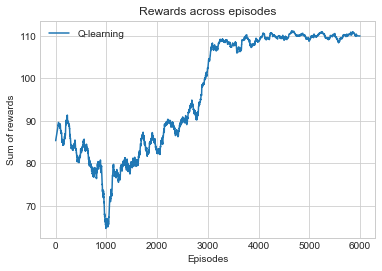

In [14]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
x = range(numIter)
#plt.ylim(-100, 0)

yhat = rewards
yhat = savgol_filter(rewards,101, 1)
plt.plot(x,yhat,label="Q-learning")


plt.title('Rewards across episodes')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards')


plt.legend()

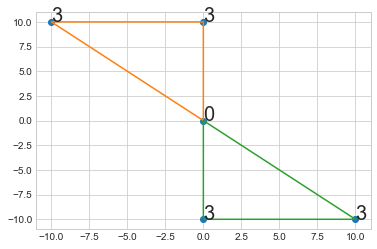

68.2842712474619


In [19]:
# Identify the deterministic policy
actions,totDistance = findPath(qsa)
actions=[0]+actions
plotPath(actions)
print(totDistance)

In [8]:
def epsilonGreedyLinear(weights,currState,epsilon):
    
    tempActionSpace = copy.deepcopy(currState.actionSpace)
            
    if currState.location != 0 
        if currState.location in tempActionSpace:
            tempActionSpace.remove(currState.location)
        
    if random.uniform(0, 1) < epsilon:    #Explore: Select action at random
        action = np.random.choice(tempActionSpace)
    
    else:                                 #Exploit: Select action based on maximum action value, use random to break ties
        currStateX = [currState.location,currState.capacity,currState.vehicles] + currState.demand[1:]
        qsa_temp = np.array([np.matmul(weights.T,np.array(currStateX + [i])) for i in tempActionSpace])
        actionIndex = np.random.choice(np.flatnonzero(qsa_temp == qsa_temp.max())) 
        action = tempActionSpace[actionIndex]
    return action

def updateWeightsLinear(weights,currState,action,nextState,reward):
    # Update the weights.    
    currStateAction = np.array([currState.location,currState.capacity,currState.vehicles] + currState.demand[1:] + [action])
    
    if nextState.vehicles == 0 :
        weights += alpha * (reward - np.matmul(weights.T,currStateAction)) * currStateAction
    else:     
        actionPrime = epsilonGreedyLinear(weights,nextState,0)
        nextStateAction = np.array([nextState.location,nextState.capacity,nextState.vehicles] + nextState.demand[1:] + [actionPrime])
        
        weights += alpha * (reward + (gamma * np.matmul(weights.T,nextStateAction)) - np.matmul(weights.T,currStateAction)) * currStateAction


In [521]:
# Linear Function Approximation

#Initialize the hyper-parameters
optInit = 0
numIter=2000                  #Number of iterations of the algorithm
alpha=0.000001                         #Learning Rate
gamma=1                          # Discount Factor - Set to 1 as this is an undiscounted task
epsilon0 = 1

# State Action defined by location of vehicle, capacity of vehicle, number of vehicles and outstanding demand.
# Frome each state the vehicle can take the action of traveling to any of the other locations.

actionSpace = list(range(N))

startState = state(demand,0,c,V,actionSpace)

# Initialize the weights vector
weights = np.ones((4+N-1))*optInit     # One weight for location, capacity, number of vehicles, demand at each location (N-1) and action

# Step throught the episodes and update the action value table
rewards = []                  #Array to maintain the rewards for each iteration

for i in range(numIter):
    currState = copy.deepcopy(startState)
    totDistance = 0
    sumReward = 0
    epsilon=epsilon0/(i//100+1) 
    
    while True:
        #currState.printState()
        # Check for terminal state
        if currState.vehicles == 0:
            rewards.append(sumReward)
            break
    

        # Choose an action based on the Epsilon-Greedy action selection.
        action = epsilonGreedyLinear(weights,currState,epsilon)

        # Identify next state and reward based on the system model
        nextState,reward,totDistance = system_model(currState,action,totDistance)
        sumReward += reward

        # Update the weights of the liner model
        updateWeightsLinear(weights,currState,action,nextState,reward)

        #Set current state to next State
        currState = nextState 


KeyboardInterrupt: 

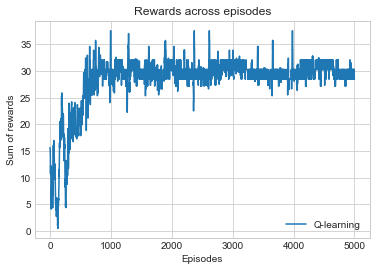

In [38]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
x = range(numIter)
#plt.ylim(-100, 0)

yhat = rewards
yhat = savgol_filter(rewards,11, 1)
plt.plot(x,yhat,label="Q-learning")


plt.title('Rewards across episodes')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards')


plt.legend()

In [11]:
print(weights)

[0.0736841  0.69570669 0.20418785 0.22971981 0.21297682 0.19032539
 0.09776917 0.25813428]


In [64]:
# NN Helper Functions
def init_weights(rows, cols):

        tensor = np.random.rand(rows,cols)
        if rows < cols:
            tensor = tensor.T
        tensor, r = np.linalg.qr(tensor)
        d = np.diag(r, 0)
        ph = np.sign(d)
        tensor *= ph

        if rows < cols:
            tensor = tensor.T
        return tensor

def epsilonGreedyNN(weights,currState,epsilon):
            
    if random.uniform(0, 1) < epsilon:    #Explore: Select action at random
        action = np.random.choice(currState.tempActionSpace)
    
    else:                                 #Exploit: Select action based on maximum action value, use random to break ties
        q_vals = getActionValues(currState,weights)
        qsa_temp = np.array([q_vals[:,i] for i in currState.tempActionSpace])
        actionIndex = np.random.choice(np.flatnonzero(qsa_temp == qsa_temp.max())) 
        action = currState.tempActionSpace[actionIndex]
    return action

def getActionValues(currState,weights):

    currStateX = np.array([currState.location,currState.capacity,currState.vehicles] + currState.demand[1:])
    
    W0, b0 = weights[0]['W'], weights[0]['b']
    psi = np.dot(currStateX.T, W0) + b0

    x = np.maximum(psi, 0)     #ReLU

    W1, b1 = weights[1]['W'], weights[1]['b']
    q_vals = np.dot(x, W1) + b1

    return q_vals

def get_TD_update(s, delta_arr,weights):
    currStateX = np.array([currState.location,currState.capacity,currState.vehicles] + currState.demand[1:])
    currStateX = currStateX.reshape((1, -1))

    W0, b0 = weights[0]['W'], weights[0]['b']
    W1, b1 = weights[1]['W'], weights[1]['b']

    psi = np.dot(currStateX, W0) + b0
    x = np.maximum(psi, 0)
    dx = (psi > 0).astype(float)

    td_update = [dict() for i in range(len(weights))]

    vt = delta_arr
    td_update[1]['W'] = np.dot(x.T, vt)
    td_update[1]['b'] = np.sum(vt, axis=0, keepdims=True)

    vt = np.dot(vt, W1.T) * dx
    td_update[0]['W'] = np.dot(currStateX.T, vt)
    td_update[0]['b'] = np.sum(vt, axis=0, keepdims=True)

    return td_update

def updateWeightsNN(weights,weightsupdate,currState,action,nextState,reward,optimizer):
    # Update the weights.    
    
    if nextState.vehicles == 0 :
        delta = reward - getActionValues(currState,weights)[:,action]
        
    else:     
        actionPrime = epsilonGreedyNN(weights,nextState,0)
        
        delta = reward + gamma * getActionValues(nextState,weights)[:,actionPrime] - getActionValues(currState,weights)[:,action]
    
    delta_arr = np.zeros((1, N))
    delta_arr[:,action] = delta 
    
    td_update = get_TD_update(currState, delta_arr, weights)
    
    weightsupdate = optimizer.update_weights(weightsupdate,td_update)
    
    return weightsupdate

def findPathNN(weights):
    currState = copy.deepcopy(startState)
    actions=[]
    totDistance = 0
    totReward = 0
    while True:
        #currState.printState()
        action = epsilonGreedyNN(weights,currState,0)
        actions.append(action)
        currState,reward,totDistance = system_model(currState,action,totDistance)
        totReward += reward
        #print(actions)
        if currState.vehicles == 0:
            return actions,totDistance,totReward


In [24]:
class Adam():
    # Work Required: Yes. Fill in the initialization for self.m and self.v (~4 Lines).
    def __init__(self, layer_sizes,step_size):
        self.layer_sizes = layer_sizes

        # Specify Adam algorithm's hyper parameters
        self.step_size = step_size
        self.beta_m = 0.9
        self.beta_v = 0.99
        self.epsilonAdam = 0.00000001
        
        # Initialize Adam algorithm's m and v
        self.m = [dict() for i in range(1, len(layer_sizes))]
        self.v = [dict() for i in range(1, len(layer_sizes))]
        
        for i in range(0, len(self.layer_sizes) - 1):
            self.m[i]["W"] = np.zeros((layer_sizes[i], layer_sizes[i + 1]))
            self.m[i]["b"] = np.zeros((1, layer_sizes[i + 1]))
            self.v[i]["W"] = np.zeros((layer_sizes[i], layer_sizes[i + 1]))
            self.v[i]["b"] = np.zeros((1, layer_sizes[i + 1]))

        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v
    
    def update_weights(self, weights, td_update):

        for i in range(len(weights)):
            for param in weights[i].keys():
              
                self.m[i][param] = self.beta_m * self.m[i][param] + (1 - self.beta_m) * td_update[i][param]
                self.v[i][param] = self.beta_v * self.v[i][param] + (1 - self.beta_v) * (td_update[i][param])**2
                m_hat = self.m[i][param]/(1 - self.beta_m_product)
                v_hat = self.v[i][param]/(1 - self.beta_v_product)
                weight_update = self.step_size * m_hat / ((v_hat)**0.5+ self.epsilonAdam)
                
                weights[i][param] = weights[i][param] + weight_update

        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v
        
        return weights

In [104]:
# NN Function Approximation
# Possible Enhancements
# Experience Replay

#Initialize the hyper-parameters
numIter= 20000                  #Number of iterations of the algorithm
alpha=0.000005                         #Learning Rate
gamma=1                          # Discount Factor - Set to 1 as this is an undiscounted task
epsilon0 = 0.35
numHiddenLayers = 5

layer_sizes = [3+N-1,numHiddenLayers,N]   #[state dimension, hidden layers, number of actions]

# State Action defined by location of vehicle, capacity of vehicle, number of vehicles and outstanding demand.
# Frome each state the vehicle can take the action of traveling to any of the other locations.

actionSpace = list(range(N))

startState = state(demand,0,c,V,actionSpace)

# Initialize the weights

weights = [dict() for i in range(0, len(layer_sizes) - 1)]
for i in range(0, len(layer_sizes) - 1):
    weights[i]['W'] = init_weights(layer_sizes[i], layer_sizes[i + 1])
    weights[i]['b'] = np.zeros((1, layer_sizes[i + 1]))

weightsupdate = copy.deepcopy(weights)

bestweights = copy.deepcopy(weights)
bestReward = float("-Inf")

optimizer = Adam(layer_sizes,alpha)

# Step throught the episodes and update the action value table
rewards = []                  #Array to maintain the rewards for each iteration

for i in range(numIter):
    if i > numIter - 5:
        actions,totDistance,totReward = findPathNN(weightsupdate)
        if totReward > bestReward:
            bestReward = totReward
            bestweights = copy.deepcopy(weightsupdate)
    
    if i % 25 == 0:
        weights = copy.deepcopy(weightsupdate)
    currState = copy.deepcopy(startState)
    totDistance = 0
    sumReward = 0
    epsilon = epsilon0/(i//1000+1) 
    
    while True:
        #currState.printState()
        
        # Check for terminal state
        if currState.vehicles == 0:
            rewards.append(sumReward)
            break
    
        # Choose an action based on the Epsilon-Greedy action selection.
        action = epsilonGreedyNN(weights,currState,epsilon)

        # Identify next state and reward based on the system model
        nextState,reward,totDistance = system_model(currState,action,totDistance)
        sumReward += reward

        # Update the weights of the NN model
        weightsupdate = updateWeightsNN(weights,weightsupdate,currState,action,nextState,reward,optimizer)

        #Set current state to next State
        currState = nextState 


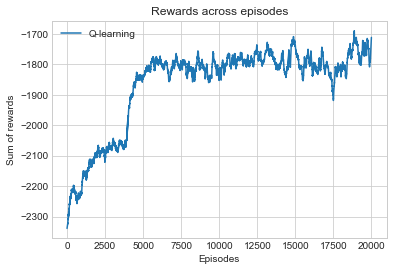

In [105]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
x = range(numIter)
#plt.ylim(-100, 0)

yhat = rewards
yhat = savgol_filter(rewards,101, 1)
plt.plot(x,yhat,label="Q-learning")


plt.title('Rewards across episodes')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards')


plt.legend()

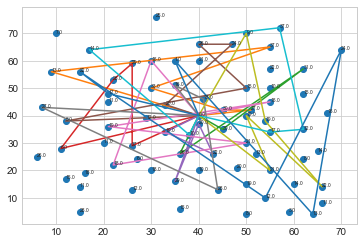

-1777.0173323587628


In [106]:
# Identify the deterministic policy
actions,totDistance,totReward = findPathNN(bestweights)
actions=[0]+actions
plotPath(actions)
print(totReward)

In [456]:
print(actions)

[0, 12, 7, 5, 11, 0, 2, 8, 3, 6, 0, 14, 15, 9, 13, 4, 1, 10, 0]


In [711]:
# Utility for computing delivery factor:
totDistance = 0 
totDemand = 0
for i in range(1,N):
    totDemand += demand[i]
    totDistance += euclidean_distance(0,i)

delivery_factor = totDistance / totDemand 

print(totDistance)
print(totDemand)
print(delivery_factor)
    

1815.4283942314
1364.0
1.330959233307478
